## Mechanisms of Action (MoA) Prediction
##### Can you improve the algorithm that classifies drugs based on their biological activity?

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load all the files

In [ ]:
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
train_features.head()

In [ ]:

print(set(train_features['cp_dose']), set(train_features['cp_time']), set(train_features['cp_type']))

### train_features has below fields for a given sig_id:

1. cp_type    
2. cp_time    
3. cp_dose
4. g-0 to g-771 (genome expression)
5. c-0 to c-99 (cell viability)

#### cp_type: 
samples treated with a compound (**trt_cp**) or with a control perturbation (**ctl_vehicle**); control perturbations have no MoAs;
#### cp_dose:
D1 (High) and D2 (Low)
#### cp_time:
24, 48, 72 hours

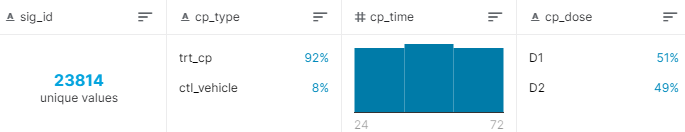

In [ ]:
train_features.info()

#### Rows: 23814 entries
#### Columns: 876 entries

In [ ]:
train_targets_scored = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")
train_targets_scored.head()

In [ ]:
train_targets_scored.info()

### train_targets_scored has below fields for a given sig_id:
**206 binary MoA targets that are scored**

In [ ]:
train_targets_nonscored = pd.read_csv("/kaggle/input/lish-moa/train_targets_nonscored.csv")
train_targets_nonscored.head()

In [ ]:
train_targets_nonscored.info()

In [ ]:
sample_sub = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
sample_sub.head()

In [ ]:
sample_sub.info()

In [ ]:
test_features = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
test_features.head()

# Encode Categorical variables into dummy variables

In [ ]:
train_features_d = pd.get_dummies(data=train_features, columns=['cp_time','cp_dose','cp_type'], drop_first=True)
test_features_d = pd.get_dummies(data=test_features, columns=['cp_time','cp_dose','cp_type'], drop_first=True)

In [ ]:
X = train_features_d.drop(['sig_id'], axis = 1)
test= test_features_d.drop(['sig_id'], axis = 1)
y = train_targets_scored.drop('sig_id', axis = 1)

# Transforming the data

### Standardizing

In [ ]:

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X = ss.fit_transform(X)
test = ss.transform(test)

# Create Training and Testing data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Training the Model

## Using XGBoost
*XGBoost is an optimized distributed gradient boosting library. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM)<br>
-xgboost.readthedocs.io*

In [ ]:
# import libraries
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


# initialize xgb classifier
classifier_XG = xgb.XGBClassifier(objective='binary:logistic', tree_method='gpu_hist')

# create MultiOutputClassifier instance to fit one classifier per target
classifier_XG_MO = MultiOutputClassifier(classifier_XG)

In [ ]:
y_train_np = y_train.iloc[:,:].to_numpy()
y_test_np = y_test.iloc[:,:].to_numpy()

In [ ]:
# reference:
# https://www.kaggle.com/fchmiel/xgboost-baseline-multilabel-classification

predictions_final = np.zeros((test.shape[0], y_train_np.shape[1]))
predictions_train = np.zeros((X_test.shape[0], y_train_np.shape[1]))

kf = KFold(n_splits=5)
for fn, (trn_idx, val_idx) in enumerate(kf.split(X_train, y_train_np)):
    print('Starting fold: ', fn)
    X_train1, X_val = X_train[trn_idx], X_train[val_idx]
    y_train1, y_val = y_train_np[trn_idx], y_train_np[val_idx]
    
    classifier_XG_MO.fit(X_train1, y_train1)
    
    preds = classifier_XG_MO.predict_proba(test)
    preds = np.array(preds)[:,:,1].T
    predictions_final += preds / 5

# Training Accuracy

In [ ]:
# from sklearn.metrics import accuracy_score
# # calculate Training accuracy

# prediction
predictions_train = classifier_XG_MO.predict(X_test)

print("Accuracy = ",accuracy_score(y_test,predictions_train))
print("\n")

# Conclusion

In [ ]:
sample_sub.iloc[:,1:] = predictions_final

In [ ]:
# from https://www.kaggle.com/isaienkov/keras-autoencoder-dae-neural-network-starter
# initializing the data for all sig_id with cp_type=='ctl_vehicle', as they have no reaction to MoAs 

sample_sub['cp_type'] = test_features_d['cp_type_trt_cp']
for col in sample_sub.columns:
    if col in ['sig_id', 'cp_type', 'cp_dose', 'cp_time']:
        continue
    sample_sub.loc[sample_sub['cp_type'] == '0', col] = 0

sample_sub = sample_sub.drop(['cp_type'], axis=1)

In [ ]:
sample_sub.to_csv('submission.csv', index=False)